# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), and evaluating your model's results (task 3).

Please upload your solved notebook to Moodle (under [Milestone 4 Submission](https://moodle.epfl.ch/mod/assign/view.php?id=1199557)) adding your team name in title, example: `m4-lernnavi-teamname.ipynb`. Please run all cells before submission so we can grade effectively.


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.

Lernnavi's dataset is formatted in three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [ ]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import os
import pickle
from functools import reduce
from collections import defaultdict

from tqdm import tqdm
import seaborn as sns
from datetime import timedelta, datetime 

from scipy.spatial.distance import jensenshannon
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics as metrics
from sklearn.neighbors import LocalOutlierFactor

from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
# from tslearn.shapelets import LearningShapelets # Requires Tensorflow

ImportError: cannot import name 'LocalOutlierFactor' from 'tslearn.neighbors' (/usr/local/lib/python3.8/dist-packages/tslearn/neighbors/__init__.py)

In [11]:
data_loc = '../../data/'
DATA_DIR = data_loc + 'raw' # You may change the directory

seed = 0

tqdm.pandas()

## Task 0: Research Question

**Research question:**
Does the study of students' behavior help predict their evaluation results?

1. To answer this question, we first focus cleaning the data to remove all inactive students. Our preprocessing aims at constituting a dataset tracking a subset of actions identified as expressing a user's activity, with a minimum number of actions characterizing active users.

2. Then we cluster the students based on a set of metrics as defined in [Shirvani Boroujeni et al](https://infoscience.epfl.ch/record/218657/files/). This is to allow the detection of an optimal student behavior.

3. Finally we perform train a time series classification model on the weekly data to predict wether a student will pass or fail its level-check evaluation.

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

### Cleaning the dataset

#### Data Loading

In [12]:
learn_sessions_transactions = pd.read_csv('{}/learn_sessions_transactions.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

#### Utils

In [13]:
def remove_users(events, transactions):
    tokens_event = set(events['transaction_token'].unique())
    print("{} tokens in events".format(len(tokens_event)))

    tokens_trans = set(transactions['transaction_token'].unique())
    print("{} tokens in transactions".format(len(tokens_trans)))

    missing_tokens = list(tokens_event - tokens_trans)
    missing_tokens.remove(np.nan)
    print("{} tokens in events but not in transactions".format(len(missing_tokens)))

    users_missing = list(events[events['transaction_token'].isin(missing_tokens)]['user_id'].unique())
    print("{} users in events but not in transactions".format(len(users_missing)))

    # Events without missing users. Equivalent to removing the missing tokens from events.
    len_events = len(events)
    events = events[~events['user_id'].isin(users_missing)]
    stat_events = (len_events - len(events))/len_events
    print("{}% of events eliminated".format(round(stat_events, 4)))

    return events, transactions

In [14]:
def create_week_number(d):
    return (d.isocalendar()[0]-2021)*53 + d.isocalendar()[1]-1

#### Automatic cleaning
The following cells are part of indications given from the teaching team for some automatic pre-cleaning of the data.

In [15]:
events, transactions = remove_users(events, transactions)

637678 tokens in events
800018 tokens in transactions
37685 tokens in events but not in transactions
1304 users in events but not in transactions
0.0595% of events eliminated


Merging `learn_sessions_transactions` dataframe with `transactions` dataframe:

In [16]:
df = transactions.merge(learn_sessions_transactions, on = 'transaction_id')
# Printing the original shape of the data
print("Original shape of the data: ", df.shape)
df.head()

Original shape of the data:  (497263, 19)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,validation,solution,type,learn_session_id,topic_id,max_num_tasks,is_closed,type_id,is_accepted
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,SKIP,NaN,NaN,111059,3250,5,0,1,NaN
1,563378,b5978bb1-c34f-4157-9d1f-052b451edab5,387604.0,1aRVNzqunJs6eJCo9vZiy3,70675,NaN,NaN,1615192571101,NaN,unknown,NaN,NaN,NaN,14120,3,5,1,1,1.0
2,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,NaN,NaN,NaN,70380,3,5,1,2,NaN
3,774545,64645a54-a4f3-4e7b-9f88-39205882d87d,387604.0,1eWCmfpLnkQ96qFQp5XixR,95079,NaN,NaN,1630399544151,1.630400e+12,unknown,SKIP,NaN,NaN,41166,3119,5,1,1,1.0
4,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,NaN,NaN,NaN,44450,3119,5,1,2,NaN


#### Cleaning criteria 1
Removing inactive students: those who did not perform any level check.
Justification of the cleaning decision: our goal is to predict user's success in level checks based on their regularity in time. As a consequence, we are not interested in users who did not perform any level check.

Computing the number of checks performed by each user on the platform:

In [17]:
test_data = pd.DataFrame(df.groupby(['user_id', 'type_id']).size())
test_data = test_data.reset_index()
test_data = test_data[test_data['type_id'] == 2]
test_data = test_data.rename(columns = {0 : "num_checks"}, errors = "raise")
test_data = test_data.drop(columns = ['type_id'])
test_data.head()

,user_id,num_checks
1,387604.0,11
3,387605.0,77
5,387608.0,53
7,387615.0,101
8,387643.0,15


Merging `df` with `test_data`:

In [18]:
df = df.merge(test_data, on = ['user_id'])

Histogram of the number of *level checks* performed by the users of the platform:

<AxesSubplot:title={'center':'Histogram of Level Checks'}, ylabel='Frequency'>

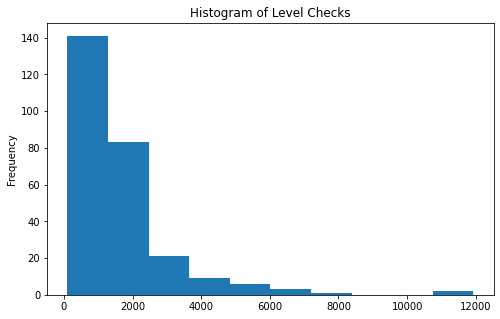

In [19]:
num_checks = df['num_checks'].value_counts(dropna=False)
num_checks.plot(
   kind="hist",
   figsize=(8,5),
   title = "Histogram of Level Checks"
)

Removing users who have not performed any level check:

In [20]:
# Printing the shape of the framework before the cleaning process:
print("Shape before cleaning: ", df.shape)

# Cleaning the data...
df = df[df['num_checks'] > 0]

# Printing the shape of the framework after the cleaning process:
print("Shape after cleaning: ", df.shape)

Shape before cleaning:  (425731, 20)
Shape after cleaning:  (425731, 20)


Dropping duplicates:

In [21]:
print("Shape with duplicates:", df.shape)
df = df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (425731, 20)
Shape without duplicates: (425731, 20)


Saving intermediate dataframe:

In [22]:
# Write a pandas dataframe df to gzipped CSV file
df.to_csv(data_loc + "processed/data_1.csv.gz", 
           index=False, 
           compression="gzip")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/data_1.csv.gz'

#### Cleaning criteria 2
Removing untrackable students: those who never did any training question or theory reading.
Justification of the cleaning decision: our goal is to predict user's success in level checks based on their regularity in time. As a consequence, we are not interested in users that have not perform any training or preparation for the level checks because we cannot measure their regularity (since they have not used the platform).

Merging `df` with `events`:

In [23]:
df = df.merge(events, on = ['user_id','transaction_token'])

Computing the number of questions submitted by each user on the platform:

In [24]:
test_data = pd.DataFrame(df.groupby(['user_id', 'action']).size())
test_data = test_data.reset_index()
test_data = test_data[test_data['action'] == ('SUBMIT_ANSWER' or 'GO_TO_THEORY')]
test_data = test_data.rename(columns = {0 : "num_participations"}, errors = "raise")
test_data = test_data.drop(columns = ['action'])
test_data.head()

,user_id,num_participations
5,387604.0,5
16,387605.0,110
22,387608.0,38
27,387615.0,7
36,387644.0,22


Merging `df` with `test_data`:

In [25]:
df = df.merge(test_data, on = 'user_id')

Histogram of the number of *participations* performed by the users of the platform:

<AxesSubplot:title={'center':'Histogram of Participations'}, ylabel='Frequency'>

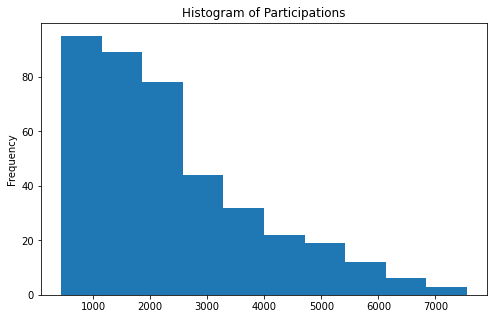

In [26]:
num_participations = df['num_participations'].value_counts(dropna=False)
num_participations.plot(
   kind="hist",
   figsize=(8,5),
   title = "Histogram of Participations"
)

Removing users who have never performed a training question or have not read any theory on the platform:

In [27]:
# Printing the shape of the framework before the cleaning process:
print("Shape before cleaning: ", df.shape)

# Cleaning the data...
df = df[df['num_participations'] > 0]

# Printing the shape of the framework after the cleaning process:
print("Shape after cleaning: ", df.shape)

Shape before cleaning:  (948029, 28)
Shape after cleaning:  (948029, 28)


Dropping duplicates:

In [28]:
print("Shape with duplicates:", df.shape)
df = df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (948029, 28)
Shape without duplicates: (948029, 28)


Saving intermediate dataframe:

In [29]:
# Write a pandas dataframe df to gzipped CSV file
df.to_csv(data_loc + "processed/data_2.csv.gz", 
           index=False, 
           compression="gzip")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/data_2.csv.gz'

#### Cleaning criteria 3
Removing inactive students: those who have not used the platform for several weeks with a minimum number of actions per week.

Adding `week_of_year` to the dataframe:

In [32]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 'ms')
df['week'] = df['timestamp'].map(lambda x: create_week_number(x))
df['week'] -= min(df['week'])
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,11,3469683,2022-02-18 15:13:38.387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,11,3469684,2022-02-18 15:13:40.545,SESSION,SKIP,CLICK,111059.0,NaN,5,40
2,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,11,1551821,2021-11-17 10:57:15.291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,5,26
3,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,11,1551834,2021-11-17 10:57:28.711,SESSION,CLOSE,CLICK,70380.0,NaN,5,26
4,774545,64645a54-a4f3-4e7b-9f88-39205882d87d,387604.0,1eWCmfpLnkQ96qFQp5XixR,95079,NaN,NaN,1630399544151,1.630400e+12,unknown,...,11,231941,2021-08-31 08:45:44.249,SESSION,REVIEW_TASK,VIEW,41166.0,NaN,5,15


Let's explore the different types of actions we have in our dataset:

In [33]:
print(set(df['action']))

{'CLOSE', 'VIEW_QUESTION', 'SUBMIT_ANSWER', 'GO_TO_BUG_REPORT', 'REQUEST_HINT', 'NEXT', 'OPEN_FEEDBACK', 'GO_TO_COMMENTS', 'SHARE', 'REVIEW_TASK', 'SKIP', 'CLOSE_FEEDBACK', 'GO_TO_THEORY'}


The actions list in the set above will be considered as **significant actions** (this actions are the ones that are in the `events` table but that also have a `transaction_token` associated in the same row), while we won't be interested in actions such as `LOGIN`, `LOGOUT` and `NAVIGATE_DASHBOARD` (see set of actions below).

In [34]:
print(set(events['action'])-set(df['action']))

{'LOGOUT', 'SURVEY_BANNER', 'VIEW_SESSION_END', 'PAGE_VISIT', 'WINDOW_OPEN', 'NAVIGATE_SURVEY', 'SUBMIT_SEARCH', 'ACCEPT_PROGRESS', 'REJECT_PROGRESS', 'GO_TO_SESSION', 'SELECT_STATISTICS', 'NAVIGATE_DASHBOARD', 'WINDOW_CLOSE', 'SHARE_SESSION', 'WINDOW_VISIBLE_FALSE', 'WINDOW_VISIBLE_TRUE', 'LOGIN', 'PRETEST'}


Computing *significant actions* per week:

In [35]:
test_data = df[['user_id', 'week', 'action']]
test_data = df.groupby(['user_id', 'week']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data.rename(columns = {0 : "num_actions_per_week"}, errors = "raise")
# Sorting the values of the dataframe `test_data`:
test_data = test_data.sort_values(['user_id', 'week'])
test_data.head()

,user_id,week,num_actions_per_week
0,387604.0,5,3
1,387604.0,6,16
2,387604.0,13,2
3,387604.0,15,29
4,387604.0,16,5


Merging `df` with `test_data`:

In [36]:
df = df.merge(test_data, on = ['user_id', 'week'])

Dropping duplicates:

In [37]:
print("Shape with duplicates:", df.shape)
df = df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (948029, 30)
Shape without duplicates: (948029, 30)


Saving intermediate dataframe:

In [38]:
# Write a pandas dataframe df to gzipped CSV file
df.to_csv(data_loc + "processed/data_3_1.csv.gz", 
           index=False, 
           compression="gzip")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/data_3_1.csv.gz'

Now, I will summarize the data using a boxplot: 

<AxesSubplot:xlabel='num_actions_per_week'>

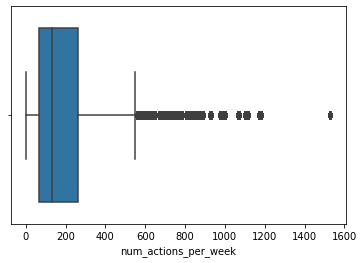

In [39]:
sns.boxplot(x = df['num_actions_per_week'])

We can appreciate in the boxplot the presence of outliers. However, we don't want to remove users with a high activity in the platform, as they can provide us with useful information in our research.
As we can appreciate in the plot, there are not outliers in the left side of the plot.
Now, I will apply the Local Outlier Factor method to detect outliers values of the column `num_actions_per_week`:

In [40]:
# Define LOF class
lof = LocalOutlierFactor() # consider playing around with 'n_neighbors' parameter

test_data = df[['user_id', 'week', 'num_actions_per_week']]

# Predict whether the numerical columns are outlier or not
y_pred = lof.fit_predict(test_data)

# Select all rows that are not outliers
mask = y_pred != -1
print("Shape with local outliers:", test_data.shape)
test_data_clean = test_data[mask]
print("Shape without local outliers:", test_data.shape)

Shape with local outliers: (948029, 3)
Shape without local outliers: (948029, 3)


It turns out that none of the rows have been deleted using this method.

Dropping duplicates:

In [41]:
print("Shape with duplicates:", df.shape)
df = df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (948029, 30)
Shape without duplicates: (948029, 30)


Saving intermediate dataframe:

In [42]:
# Write a pandas dataframe df to gzipped CSV file
df.to_csv(data_loc + "processed/data_3_2.csv.gz", 
           index=False, 
           compression="gzip")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/data_3_2.csv.gz'

In [43]:
# Printing the shape of the framework before the cleaning:
print("Shape before cleaning: ", df.shape)

# Cleaning process
df = df[df['num_actions_per_week'] > 4]

# Printing the shape of the framework after the cleaning:
print("Shape after cleaning: ", df.shape)

Shape before cleaning:  (948029, 30)
Shape after cleaning:  (944645, 30)


*Definition:* A **significant week** of a particular user is a week in which that user has performed at least $2$ (the closer integer to the lower bound we have defined aboved) significant actions. Note that we have just deleted of our dataframe of the weeks that are not significant.

Computing the total number of weeks that each user has been actived in the platform:

In [44]:
test_data = df[['user_id', 'week']].drop_duplicates()
test_data = pd.DataFrame(test_data.groupby(['user_id']).size()).reset_index()
test_data = test_data.rename(columns = {0 : "num_weeks_per_user"}, errors = "raise")
test_data.head()

,user_id,num_weeks_per_user
0,387604.0,6
1,387605.0,13
2,387608.0,5
3,387615.0,1
4,387644.0,2


Merging `df` with `test_data`:

In [45]:
df = df.merge(test_data, on = 'user_id')

Dropping duplicates:

In [46]:
print("Shape with duplicates:", df.shape)
df = df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (944645, 31)
Shape without duplicates: (944645, 31)


Saving intermediate dataframe:

In [47]:
# Write a pandas dataframe df to gzipped CSV file
df.to_csv(data_loc + "processed/data_3_3.csv.gz", 
           index=False, 
           compression="gzip")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/data_3_3.csv.gz'

Now, I will summarize the data using a boxplot:

<AxesSubplot:xlabel='num_weeks_per_user'>

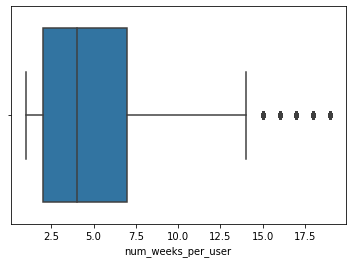

In [48]:
sns.boxplot(x = df['num_weeks_per_user'])

We can appreciate in the boxplot the presence of outliers. However, we don't want to remove users with a high activity in the platform, as they can provide us with useful information in our research.
As we can appreciate in the plot, there are not outliers in the left side of the plot.
Now, I will apply the Local Outlier Factor method to detect outliers values of the column `num_weeks_per_user`:

In [49]:
# Define LOF class
lof = LocalOutlierFactor(n_neighbors = 2) # consider playing around with 'n_neighbors' parameter

test_data = df[['user_id', 'num_weeks_per_user']]

# Predict whether the numerical columns are outlier or not
y_pred = lof.fit_predict(test_data)

# Select all rows that are not outliers
mask = y_pred != -1
print("Shape with local outliers:", test_data.shape)
test_data_clean = test_data[mask]
print("Shape without local outliers:", test_data.shape)

Shape with local outliers: (944645, 2)
Shape without local outliers: (944645, 2)


It turns out that none of the rows have been deleted using this method.

Deleting rows corresponding to users with less than $2$ significant weeks (since we are interested in doing a time series analysis):

In [50]:
# Printing the shape of the framework before the cleaning:
print("Shape before cleaning: ", df.shape)

# Cleaning process...
df = df[df['num_weeks_per_user'] > 1]

# Printing the shape of the framework after the cleaning process:
print("Shape after cleaning: ", df.shape)

Shape before cleaning:  (944645, 31)
Shape after cleaning:  (790425, 31)


In [54]:
final_df = df.drop(columns = ['transaction_id', 'transaction_token', 'document_id', 'document_version', 'user_agent', 'validation', 'solution', 'type', 'learn_session_id', 'topic_id', 'is_closed', 'type_id', 'is_accepted', 'event_id', 'session_id', 'tracking_data', 'evaluation', 'input', 'event_type', 'max_num_tasks'])
final_df = final_df[['user_id', 'timestamp', 'week', 'category', 'action', 'start_time', 'commit_time', 'num_checks', 'num_participations', 'num_actions_per_week', 'num_weeks_per_user']]
final_df.head()

,user_id,timestamp,week,category,action,start_time,commit_time,num_checks,num_participations,num_actions_per_week,num_weeks_per_user
0,387604.0,2022-02-18 15:13:38.387,40,SESSION,REVIEW_TASK,1645197218251,1.645197e+12,11,5,7,6
1,387604.0,2022-02-18 15:13:40.545,40,SESSION,SKIP,1645197218251,1.645197e+12,11,5,7,6
2,387604.0,2022-02-18 15:13:43.057,40,SESSION,REVIEW_TASK,1645197222948,NaN,11,5,7,6
3,387604.0,2022-02-18 15:13:30.415,40,SESSION,REVIEW_TASK,1645197210317,1.645197e+12,11,5,7,6
4,387604.0,2022-02-18 15:13:37.975,40,SESSION,SKIP,1645197210317,1.645197e+12,11,5,7,6


I have not deleted `start_time` and `commit_time` because it may be interesting to know the amount of time a user has spent performing an action. I am dropping `evaluation` and `input` columns because we are not interested in whether a question is correct or not but in the result obtain in the whole level check.

Making sure there are no duplicates lines in the data:

In [52]:
print("Shape with duplicates:", df.shape)
final_df = final_df.drop_duplicates()
print("Shape without duplicates:", df.shape)

Shape with duplicates: (790425, 31)
Shape without duplicates: (790425, 31)


Saving the final version of the data:

In [53]:
# Write a pandas dataframe df to gzipped CSV file
final_df.to_csv(data_loc + "processed/data.csv.gz", 
           index=False, 
           compression="gzip")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/data.csv.gz'

### Cantonal representation within the data set

This is an exploratory detour to investigate how certain groups of students might form/differ during our research. The most obvious groupings of students already present in the dataset are by canton and by year group. 

#### Data Loading

In [ ]:
users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
lst = learn_sessions_transactions

#### Utils

In [ ]:
def activity_per(colname):
    """
    Return activity per user for specified grouping of users (canton or class_level).
    """
    
    users_per = users[['user_id', colname]]
    size_per = users_per.pivot_table(index=colname, values=['user_id'], aggfunc='nunique').reset_index()
    
    activity_per = transactions.merge(users_per, on='user_id', how='left')
    transactions_per = activity_per.pivot_table(index=colname, 
                                                values=['transaction_id', 'user_id'], 
                                                aggfunc={'transaction_id':'count', 'user_id':'nunique'}).reset_index()
    transactions_per['trans_per_user'] = transactions_per['transaction_id']/transactions_per['user_id']
    
    return users_per, size_per, transactions_per 

In [41]:
#outliers 
def show_outliers(df, colname, method):
    """
    Return outliers of a certain column in dataframe df by a chosen method (IQR or std).
    """
    
    if method == 'IQR':
        q1 = df[colname].quantile(0.25)
        q3 = df[colname].quantile(0.75)
        iqr = q3-q1
        lb = q1 - 1.5*iqr
        ub = q3 + 1.5*iqr
        
        print(f"Lower bound: {lb}")
        print(f"Upper bound: {ub}")
        
        out = df[(df[colname] < lb) | (df[colname] > ub)]
        
        return out
        
    if method == 'std':
        mean = df[colname].mean()
        std = df[colname].std()
        lb = mean - 1*std
        ub = mean + 1*std
        
        print(f"Lower bound: {lb}")
        print(f"Upper bound: {ub}")
        out = df[(df[colname] < lb) | (df[colname] > ub)]
        
        return out 

#### Exploration

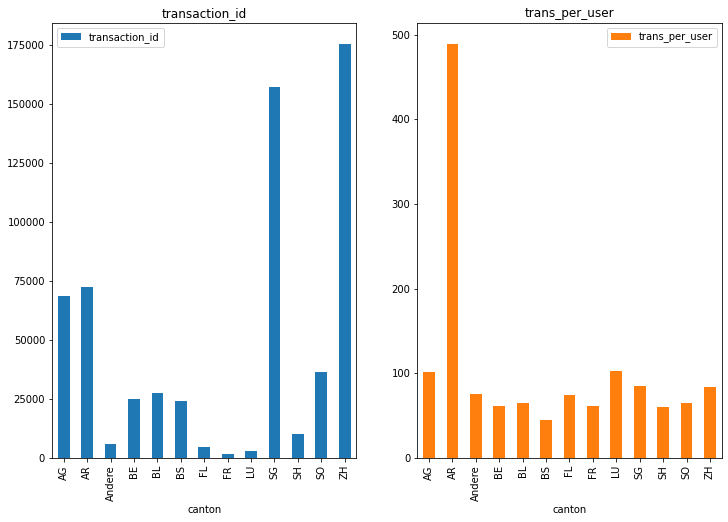

In [46]:
users_canton, canton_size, canton_transactions = activity_per('canton')
ax = canton_transactions.plot.bar(x='canton', 
                                  y=['transaction_id', 'trans_per_user'], 
                                  subplots=True, 
                                  layout=(1,2),
                                  figsize=(12,8))

<AxesSubplot:xlabel='canton'>

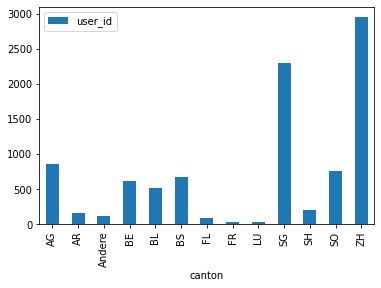

In [47]:
canton_size.plot.bar(x='canton', y='user_id')
plt.show()

These bar plots show us that cantons with greater numbers of students have a larger transaction count **overall**. However, most cantons, with the exception of AR show similar numbers of transactions *per user*.  

#### Class (level) representation in the data set

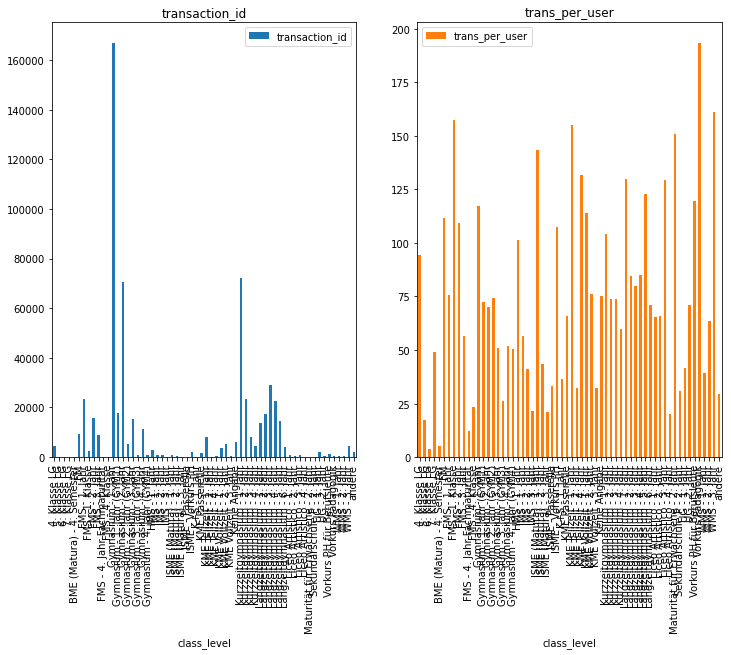

In [49]:
users_class, class_size, class_transactions = activity_per('class_level')

ax = class_transactions.plot.bar(x='class_level', 
                                 y=['transaction_id', 'trans_per_user'], 
                                 subplots=True, 
                                 layout=(1,2),
                                 figsize=(12,8)) #lots and lots of classes

### Regularity metrics computation

#### Data Loading

In [ ]:
users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))
lst = pd.read_csv('{}/learn_sessions_transactions.csv.gz'.format(DATA_DIR))
data_clean = pd.read_csv('{}/data_clean.csv.gz'.format(DATA_DIR))

#### Utils

With the exception of `create_week_number` the these functions below are taken directly from the flipped_classroom ML4ED repository. 

In [5]:
def similarity_days(wi, wj):
    m1, m2 = np.where(wi == 1)[0], np.where(wj == 1)[0]
    if len(m1) == 0 or len(m2) == 0:
        return 0
    return len(np.intersect1d(m1, m2)) / max(len(m1), len(m2))

In [6]:
def chi2_divergence(p1, p2, a1, a2):
    a = p1 - p2
    b = p1 + p2
    frac = np.divide(a, b, out=np.zeros(a.shape, dtype=float), where=b != 0)
    m1 = np.where(a1 > 0)[0]
    m2 = np.where(a2 > 0)[0]
    union = set(m1) & set(m2)
    if len(union) == 0: return np.nan
    return 1 - (1 / len(union)) * np.sum(np.square(frac))

In [8]:
def time_measures(data, mode, weeks):
    data = data[data['week'] < weeks]
    if mode == 'dayhour':
        hours = data['date'].dt.hour.astype(int).to_list()
        activity = np.array([hours.count(h) for h in np.arange(24)])
        if np.sum(activity) == 0:
            print("Feature is invalid: the dayhour mode is invalid. Returning nan.")
            return np.nan
        entropy = stats.entropy(activity / np.sum(activity))
        return (np.log(24) - entropy) * np.max(activity)
    elif mode == 'weekday':
        weekdays = data['date'].dt.weekday.astype(int).to_list()
        activity = np.array([weekdays.count(h) for h in np.arange(7)])
        if np.sum(activity) == 0:
            print("Feature is invalid: the weekday mode is invalid. Returning nan.")
            return np.nan
        entropy = stats.entropy(activity / np.sum(activity))
        return (np.log(7) - entropy) * np.max(activity)

In [9]:
def time_measures_plot_student(student, data, mode, weeks):
    """
    Plot the 'hour of day' and 'day of week' activity of a user for weeks usage of the platform.
    """
    
    
    data = data[data['user_id'] == student]
    data = data[data['week'] < weeks]
    if mode == 'dayhour':
        hours = data['date'].dt.hour.astype(int).to_list()
        activity = np.array([hours.count(h) for h in np.arange(24)])
        time_measure_data = pd.DataFrame({'hour' : np.arange(24), 'count' : activity})
        
        time_measure_data.plot.bar(x='hour', y='count', rot=0)
        plt.xlabel("Hour of day")
        plt.ylabel("Count")

    elif mode == 'weekday':
        weekdays = data['date'].dt.weekday.astype(int).to_list()
        activity = np.array([weekdays.count(h) for h in np.arange(7)])
        time_measure_data = pd.DataFrame({'weekday' : np.arange(7), 'count' : activity})
        
        time_measure_data.plot.bar(x='weekday', y='count', rot=0)
        plt.xlabel("Day of week")
        plt.ylabel("Count")  

In [10]:
def create_week_number(d):
    return (d.isocalendar()[0] - 2021) * 53 + d.isocalendar()[1] - 1
# https://stackoverflow.com/questions/59425176/how-to-continue-the-week-number-when-the-year-changes-using-pandas

In [11]:
def profile_similarity(data, mode, weeks):
    data['weekday'] = data['date'].dt.weekday.astype(int)
    data = data[data['week'] < weeks]
    
    workload = np.zeros((weeks, 7))
    workload[data['week'], data['weekday']] += 1
    hist = workload / np.sum(workload)

    # Hours of activity starting at midnight of the first timestamp
    hours = (data['date']).values.astype(np.int64) // 10 ** 9 // 3600
    min_day = data.date.min() # First day of activity
    # Make the hours start from midnight of the first day
    hours -= int(datetime(min_day.year, min_day.month, min_day.day).timestamp() / 3600)

    period_length = weeks * 7 * 24
    activity = np.array([int(t in hours) for t in range(period_length)]).reshape((weeks, 7 * 24))
    activity = np.array([week.reshape((7, 24)).sum(axis=1) for week in activity])  # shape (weeks, 7)
    if mode == 'm1':
        return np.mean([similarity_days(workload[i], workload[j]) for i in range(workload.shape[0]) for j in range(i+1, workload.shape[0])])
    elif mode == 'm2':
        res = []
        for i in range(activity.shape[0]):
            for j in range(i + 1, activity.shape[0]):
                if not activity[i].any() or not activity[j].any():
                    continue
                res.append(1 - jensenshannon(activity[i], activity[j], 2.0))
        if len(res) == 0:
            #print("Feature is invalid. Will return nan")
            return np.nan
        return np.mean(np.clip(np.nan_to_num(res), 0, 1))
    elif mode == 'm3':
        res = []
        for i in range(activity.shape[0]):
            for j in range(i + 1, activity.shape[0]):
                if not activity[i].any() or not activity[j].any():
                    continue
                res.append(chi2_divergence(activity[i], activity[j], hist[i], hist[j]))
        if len(res) == 0:
            return np.nan
        return np.mean(np.nan_to_num(res))

In [12]:
def fourier_transform(Xi, f, n):
    return np.dot(np.exp(-2j * np.pi * f * n), Xi)

In [13]:
def freq(data, mode, weeks):
    if mode == 'm1':
        # Convert date to hours starting from 0
        hours = data['date'].values.astype(np.int64) // 10 ** 9 // 3600
        hours -= min(hours)
        period_length = weeks * 7 * 24
        activity = np.array([int(t in hours) for t in range(period_length)])  # 1 if active at hour t 0 o.w.
        if np.sum(activity) == 0:
            #logging.debug('feature {} is invalid: the m1 mode is invalid'.format(self.name))
            return np.nan #Feature.INVALID_VALUE
        n = np.arange(period_length)
        return abs(fourier_transform(activity, 1 / 24, n))

    elif mode == 'm2':
        period_length = weeks * 7 * 24
        hours = data['date'].values.astype(np.int64) // 10 ** 9 // 3600
        hours -= min(hours)
        activity = np.array([int(t in hours) for t in range(period_length)])
        n = np.arange(period_length)
        return abs(fourier_transform(activity.flatten(), 1 / (7 * 24), n))

    elif mode == 'm3':
        # Convert date to days starting from 0
        days = data['date'].values.astype(np.int64) // 10 ** 9 // (24 * 3600)
        days -= min(days)
        period_length = weeks * 7
        activity = np.array([int(d in days) for d in range(period_length)])  # 1 if active at day d 0 o.w.
        n = np.arange(period_length)
        return abs(fourier_transform(activity, 1 / 7, n))

In [79]:
def compute_agg_regularity(data, weeks):
    
    #time based measures
    PDH = data.groupby('user_id').apply(lambda x: time_measures(x, 'dayhour', weeks)).reset_index()
    PWD = data.groupby('user_id').apply(lambda x: time_measures(x, 'weekday', weeks)).reset_index(drop=True)
    
    #profile similarity 
    WS1 = data.groupby('user_id').apply(lambda x: profile_similarity(x, 'm1', weeks)).reset_index(drop=True)
    WS2 = data.groupby('user_id').apply(lambda x: profile_similarity(x, 'm2', weeks)).reset_index(drop=True)
    WS3 = data.groupby('user_id').apply(lambda x: profile_similarity(x, 'm3', weeks)).reset_index(drop=True)
    
    #frequency based measures
    FDH = data.groupby('user_id').apply(lambda x: freq(x, 'm1', weeks)).reset_index(drop=True)
    FWH = data.groupby('user_id').apply(lambda x: freq(x, 'm2', weeks)).reset_index(drop=True)
    FWD = data.groupby('user_id').apply(lambda x: freq(x, 'm3', weeks)).reset_index(drop=True)
    
    reg_features = pd.concat([PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD], axis=1, ignore_index=False)
    
    return reg_features 

In [94]:
def calculate_pvalues(df):
    """
    Return the p-values for the test for correlation between two numerical features.
    """
    
    
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(stats.pearsonr(df[r], df[c])[1], 4)
    return pvalues

#### Building the regularity features

In [81]:
data_clean.rename(columns={'timestamp':'date'}, inplace=True)
data_clean['date'] = pd.to_datetime(data_clean['date'])

#data_clean.info()
data_clean.drop(['start_time', 'commit_time'], axis=1, inplace=True)

In [85]:
no_weeks = max(data_clean.week) + 1
reg_features = compute_agg_regularity(data_clean, no_weeks)

reg_features.columns = ['user_id', 'PDH', 'PWD', 'WS1', 'WS2', 'WS3', 'FDH', 'FWH', 'FWD']
reg_features.drop('user_id', axis=1).describe()

In [90]:
reg_features.drop('user_id', axis=1).corr()

,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
PDH,1.000000,0.661052,0.347986,0.211583,0.122882,0.290867,0.283191,0.349597
PWD,0.661052,1.000000,0.543699,0.292506,0.039472,0.373046,0.531588,0.522008
WS1,0.347986,0.543699,1.000000,0.146237,-0.078301,0.754746,0.787021,0.863204
WS2,0.211583,0.292506,0.146237,1.000000,0.178355,0.003762,0.109581,0.200993
WS3,0.122882,0.039472,-0.078301,0.178355,1.000000,-0.107785,-0.092193,-0.067743
FDH,0.290867,0.373046,0.754746,0.003762,-0.107785,1.000000,0.766441,0.689512
FWH,0.283191,0.531588,0.787021,0.109581,-0.092193,0.766441,1.000000,0.897766
FWD,0.349597,0.522008,0.863204,0.200993,-0.067743,0.689512,0.897766,1.000000


In [96]:
calculate_pvalues(reg_features.drop('user_id', axis=1))  #features are mostly well correlated

,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
PDH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PWD,0.0,0.0,0.0,0.0,0.0495,0.0,0.0,0.0
WS1,0.0,0.0,0.0,0.0,0.0001,0.0,0.0,0.0
WS2,0.0,0.0,0.0,0.0,0.0,0.8516,0.0,0.0
WS3,0.0,0.0495,0.0001,0.0,0.0,0.0,0.0,0.0007
FDH,0.0,0.0,0.0,0.8516,0.0,0.0,0.0,0.0
FWH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FWD,0.0,0.0,0.0,0.0,0.0007,0.0,0.0,0.0


---

In [101]:
calculate_pvalues(reg_features_ans_submission.drop('user_id', axis=1)) 

,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
PDH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PWD,0.0,0.0,0.0,0.0,0.0125,0.0,0.0,0.0
WS1,0.0,0.0,0.0,0.0,0.0003,0.0,0.0,0.0
WS2,0.0,0.0,0.0,0.0,0.0,0.5696,0.0,0.0
WS3,0.0,0.0125,0.0003,0.0,0.0,0.0,0.0,0.0019
FDH,0.0,0.0,0.0,0.5696,0.0,0.0,0.0,0.0
FWH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FWD,0.0,0.0,0.0,0.0,0.0019,0.0,0.0,0.0


In [108]:
reg_features.to_csv(data_loc + 'processed/user_reg_features.csv.gz', compression='gzip', index=False)

---

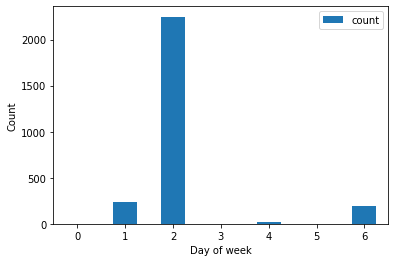

In [86]:
idx = reg_features['PWD'].idxmax()
student_clean = reg_features['user_id'].loc[idx]
time_measures_plot_student(student_clean, data_clean, 'weekday', no_weeks) #plots reflect what's in the ML4ED paper.

### Getting Level Checks

The level checks scores are obtained as described in the [FAQ](https://docs.google.com/document/d/1RFcn1Y_o_MLfQo0-od8W7-Ty2rfhXZRnIVG0CLPl0NM/edit).

#### Data Loading

In [13]:
topics_translated = pd.read_csv('{}/topics_translated.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))

#### Utils
Creation of utility data structures & function definitions.

In [14]:
# Creating dictionary of topic ids, names and category (math/german)
topics_dict = topics_translated[['id', 'name_english', 'math']]
display(topics_dict.head(3))

,id,name_english,math
0,1,German,0.0
1,2,spelling,0.0
2,3,Spelling principles,0.0


In [15]:
def get_topic_name(_id, topics_dict = topics_dict, verbose = False):
    """
    Uses the topics_dict to get the english name of a topic given its id.
    """
    tmp = topics_dict.loc[topics_dict.id == _id, 'name_english'].reset_index(drop=True)
    if (tmp.shape[0] == 0):
        if verbose : print(f"Did not find any topic for id {_id}")
        return ''
    else : 
        return tmp.iloc[0]
    
def is_math(_id, topics_dict = topics_dict, verbose = False):
    """
    Uses the topics_dict to indicate wether the topic is a math topic or not (German topic) using its id.
    """
    tmp = topics_dict.loc[topics_dict.id == _id, 'math'].reset_index(drop=True)
    if (tmp.shape[0] == 0):
        if verbose : print(f"Did not find any topic for id {_id}")
        return None
    else : 
        return tmp.iloc[0] == 1

In [16]:
def get_keys(js, n) :
    """
    Prints out all keys of a json file.
    """
    if type(js) == dict:
        for k in js.keys():
            print('\t'*n + k)
            get_keys(js[k], n+1)
    elif type(js) == list:
        print('\t'*n + '[')        
        for i in js:
            get_keys(i, n)
            print('\t'*n + ',')
        print('\t'*n + ']')
    else :
        print('\t'*n + "...")

In [17]:
# Getting all the primary (non children) topics of a specific navigate_dashbard event

def get_mastery(topic, n=0, scores = None, verbose=False):
    """
    Stores all the mastery scores for the input topic and its children. 
    Stops the recursion when no children or a non-zero mastery score is encountered.
    """
    # create cumulative dict to pass store mastery scores if None
    scores = {}
    
    # get data
    data = topic["userData"]
    
    # Get id and level of mastery
    mastery = float(data["mastery"])
    
    # get topic id and name info
    topic_id = topic["topic"]["id"]
    topic_name = get_topic_name(topic_id)
    topic_math = 'Math' if is_math(topic_id) else 'German'
    
    # result
    if verbose: print('\t'*n + f"[{topic_math}] {topic_name} ({topic_id}): {mastery}")
    
    # Get the topic's children if any
    try :
        children = topic['children']
    except :
        children = []
        
    # If mastery is 0, dig deeper and try to get a non-0 score
    if (mastery == 0.) and (len(children) > 0) :
        for t in children:
            scores.update(get_mastery(t, n=n+1, scores=scores, verbose=verbose))
    else :
        scores[topic_id] = mastery * 10
    
    return scores

In [18]:
def get_level(js, verbose = False):
    if type(js) != dict: js = json.loads(js)
    all_scores = {}
    
    try:
        topics = js['dashboard']['topics']
    except :
        topics = []
    
    for topic in topics:
        all_scores.update( get_mastery(topic, scores=all_scores, verbose = verbose) )

    return all_scores

In [19]:
def get_level_changes(levels):
    """
    Note: This assumes that the user can never get 0.0 as a mastery score. 0.0 denotes absence of value.
    """
    
    # Get levels as list to work with indexes
    if type(levels) != list : levels = levels.tolist()
    
    # set initial state (stores the previous non empty scores, defaults to 0)
    previous_state = defaultdict(lambda : 0.)
    # Create list to track changes
    changes = []
    
    # Loop through all the checks and track the changes.
    for level in levels:
        _changes = {}
        
        # For each key, check if it changed compared to its previously saved value
        for k in level.keys() :
            _previous = previous_state[k]
            _current = level[k]
            
            if (_previous != _current) :
                # compute change
                _change = _current - _previous
                # store (current, change)
                _changes[k] = (_current, _change)
            
            previous_state[k] = _current
    
        changes.append(_changes)
    
    return changes

In [20]:
def build_change_df(df):
    """
    Isolates the level change events per date and per topic for the input user.
    Note: The validated mark looks at the change in level. If the change is positive, 
    we assume that the user progressed and thus we validate the level check
    """
    tmp2 = df.copy()

    # Get only the singleton changes per topic
    tmp2['change'] = tmp2.change.apply(lambda d : [(_id, *d[_id]) for _id in d.keys()])
    tmp2 = tmp2[['date', 'change']].explode("change")
    # remove empty rows (no changes at these dates)
    tmp2 = tmp2.loc[~tmp2.change.isna()].reset_index(drop=True)

    # Assign a validated or failed mark
    # validation holds on wether the change is positive (level got higher) or not
    tmp2['validated'] = tmp2.change.apply(lambda t: t[2] > 0)

    # Get topic name
    tmp2['topic'] = tmp2.change.apply(lambda t : get_topic_name(t[0]))
    
    return tmp2

#### Discovery

In [21]:
# Exploring json data file of first NAVIGATE_DASHBOARD activity
line = events[events['action']=='NAVIGATE_DASHBOARD'].iloc[1]
l0 = json.loads(line['tracking_data'])

# >>>>> uncomment to see key structure
# get_keys(l0, 0)

# >>>>> uncomment to see raw content
# l0

In [22]:
# Getting all mastery scores for a single event
get_level(l0, verbose=True)

[German] spelling (2): 0.0
	[German] Spelling principles (3): 0.737535316620025
	[German] Large and lower case (2055): 0.3981179459718665
	[German] Spellishly difficult words (2065): 0.11930505543060275
[German] punctuation (3104): 0.0
	[German] Comma in sentence (3163): 0.4325001746856052
[German] Speech (3105): 0.0
	[German] Verb (3110): 0.04742587317756678
	[German] noun (3111): 0.04742587317756678
	[German] Adjectives (3179): 0.04742587317756678
	[German] pronoun (3112): 0.04742587317756678
	[German] Particle (3113): 0.04742587317756678
[German] sentence parts (3106): 0.0
	[German] Function of the sentence members (3141): 0.04742587317756678
	[German] Determination of the sentence members (3142): 0.04742587317756679
	[German] Structure of phrases (3154): 0.04742587317756678
	[German] Congress between phrases (3156): 0.04742587317756678
[German] Phenomena (3107): 0.0
	[German]  (3244): 0.04742587317756678
	[German] Relationship between phrases / attributes and sidelines (3250): 0.04

{3: 7.3753531662002505,
 2055: 3.981179459718665,
 2065: 1.1930505543060275,
 3163: 4.325001746856052,
 3110: 0.4742587317756678,
 3111: 0.4742587317756678,
 3179: 0.4742587317756678,
 3112: 0.4742587317756678,
 3113: 0.4742587317756678,
 3141: 0.4742587317756678,
 3142: 0.4742587317756679,
 3154: 0.4742587317756678,
 3156: 0.4742587317756678,
 3244: 0.4742587317756678,
 3250: 0.4742587317756678,
 2023: 0.4742587317756678,
 2042: 0.4742587317756678,
 2045: 0.8331439759984216,
 2048: 0.4742587317756678,
 3114: 0.4742587317756678,
 3115: 0.4742587317756678,
 3116: 0.4440693277319837,
 3117: 0.0,
 3119: 0.0}

In [23]:
# Testing out tracking the evolution for a single user
events[events['action']=='NAVIGATE_DASHBOARD'].iloc[1]

user_id = 390028
tmp = events.loc[(events.user_id == user_id) & (events.action == 'NAVIGATE_DASHBOARD'), ['timestamp', 'tracking_data']]

# Transforming to date
tmp['date'] = pd.to_datetime(tmp.timestamp, unit='ms')
# extracting all the mastery scores
tmp['levels'] = tmp.tracking_data.apply(get_level)

tmp.head(3)

,timestamp,tracking_data,date,levels
17006,1622773391671,"{""text"": ""Jetzt starten"", ""title"": ""Go To Dash...",2021-06-04 02:23:11.671,{}
17007,1622773392297,"{""dashboard"": {""title"": ""Deutsch"", ""topics"": [...",2021-06-04 02:23:12.297,"{3: 7.3753531662002505, 2055: 3.98117945971866..."
17008,1622773423216,"{""text"": ""open"", ""title"": ""TopicTileDialog"", ""...",2021-06-04 02:23:43.216,{}


In [24]:
# Making sure that the values are sorted from earliest to latest
tmp.sort_values('date', inplace=True)

In [25]:
# get changes for each non-zero mastery score if any, result is scored as (current, change)
tmp['change'] = get_level_changes(tmp.levels)
tmp.head()

,timestamp,tracking_data,date,levels,change
17006,1622773391671,"{""text"": ""Jetzt starten"", ""title"": ""Go To Dash...",2021-06-04 02:23:11.671,{},{}
17007,1622773392297,"{""dashboard"": {""title"": ""Deutsch"", ""topics"": [...",2021-06-04 02:23:12.297,"{3: 7.3753531662002505, 2055: 3.98117945971866...","{3: (7.3753531662002505, 7.3753531662002505), ..."
17008,1622773423216,"{""text"": ""open"", ""title"": ""TopicTileDialog"", ""...",2021-06-04 02:23:43.216,{},{}
17009,1622773430086,"{""text"": ""OpenSession: 35248"", ""title"": ""Topic...",2021-06-04 02:23:50.086,{},{}
17030,1622773707078,"{""dashboard"": {""title"": ""Deutsch"", ""topics"": [...",2021-06-04 02:28:27.078,"{3: 7.3753531662002505, 2055: 3.98117945971866...",{}


In [26]:
# build change df
build_change_df(tmp).head()

,date,change,validated,topic
0,2021-06-04 02:23:12.297,"(3, 7.3753531662002505, 7.3753531662002505)",True,Spelling principles
1,2021-06-04 02:23:12.297,"(2055, 3.981179459718665, 3.981179459718665)",True,Large and lower case
2,2021-06-04 02:23:12.297,"(2065, 1.1930505543060275, 1.1930505543060275)",True,Spellishly difficult words
3,2021-06-04 02:23:12.297,"(3163, 4.325001746856052, 4.325001746856052)",True,Comma in sentence
4,2021-06-04 02:23:12.297,"(3110, 0.4742587317756678, 0.4742587317756678)",True,Verb


#### Applying to all users

Running the routine to get all level checks for all users.

In [27]:
target_data_path = '../../data/processed/level_checks/'

path = data_loc + 'processed/user_reg_features.csv.gz'
df_features = pd.read_csv(path)

In [28]:
users = df_features.user_id.unique()
_done = os.listdir(target_data_path)

# level_checks = []

for u in tqdm(users):
    # Setting file names and paths
    filename = 'df_level_checks_'+str(int(u))+'.pickle'
    
    # Checking if already precomputed
    if filename in _done:
        continue
    
    # Getting all relevant events for the current user
    tmp = events.loc[(events.user_id == user_id) & (events.action == 'NAVIGATE_DASHBOARD'), ['timestamp', 'tracking_data']]

    # Transforming to date
    tmp['date'] = pd.to_datetime(tmp.timestamp, unit='ms')
    
    # extracting all the mastery scores
    tmp['levels'] = tmp.tracking_data.apply(get_level)
    
    # Making sure that the values are sorted from earliest to latest
    tmp.sort_values('date', inplace=True)
    
    # Computing the changes in levels
    tmp['change'] = get_level_changes(tmp.levels)
    
    # Building the level check df
    tmp = build_change_df(tmp)
    
    # Adding user info
    tmp['user_id'] = u
    
    # level_checks.append(tmp)
    
    # Saving file in case RAM cannot hold all
    target_path = target_data_path + filename
    pd.to_pickle(tmp, target_path)
    
# pd.concat(level_checks)

100%|███████████████████████████████████████████████████████████████████████████| 2656/2656 [00:00<00:00, 48295.25it/s]


In [31]:
# Get all files and concatenate them into one single dataframe
path = data_loc + 'processed/level_checks/'
target_path = data_loc + 'processed/'

# Loading file references
files = os.listdir(path)
files = [f for f in files if 'df_level_check' in f]

# Creating the final dataframe
df_level_check = pd.read_pickle(path + files[0])

_precomputed = 'df_level_check.csv.gz'
if _precomputed not in os.listdir(target_path) :
    for f in tqdm(files[1:]):
        tmp = pd.read_pickle(path + f)
        df_level_check = pd.concat([df_level_check, tmp])

else : 
    print(f"{_precomputed} was found in {target_path}!")
    df_level_check = pd.read_csv(target_path + 'df_level_check.csv.gz', index_col=0)

df_level_check

df_level_check.csv.gz was found in ../../data/processed/!


,user_id,date,change,validated,topic
0,387604,2021-06-04 02:23:12.297,"(3, 7.3753531662002505, 7.3753531662002505)",True,Spelling principles
1,387604,2021-06-04 02:23:12.297,"(2055, 3.981179459718665, 3.981179459718665)",True,Large and lower case
2,387604,2021-06-04 02:23:12.297,"(2065, 1.1930505543060275, 1.1930505543060275)",True,Spellishly difficult words
3,387604,2021-06-04 02:23:12.297,"(3163, 4.325001746856052, 4.325001746856052)",True,Comma in sentence
4,387604,2021-06-04 02:23:12.297,"(3110, 0.4742587317756678, 0.4742587317756678)",True,Verb
...,...,...,...,...,...
111547,404536,2021-11-28 03:16:16.688,"(3109, 1.5585101283268417, 1.5567016792527675)",True,Text production
111548,404536,2021-11-28 03:26:32.396,"(2, 1.4131972925125624, -0.030531261187065617)",False,spelling
111549,404536,2021-12-05 16:55:42.976,"(2, 1.7984165885351513, 0.38521929602258886)",True,spelling
111550,404536,2022-01-07 03:24:45.122,"(3108, 1.0576484228138745, 0.9997780524435042)",True,Textual reception


In [34]:
# Saving aggregated df
df_level_check.reset_index(drop=True, inplace=True)
df_level_check = df_level_check[['user_id', 'date', 'change', 'validated', 'topic']]

display(df_level_check.head(2))

filename = 'processed/df_level_check.csv.gz'
path = data_loc + filename
_check = input(f"Are you certain that you want to save {filename} to {path}? \n[yes/no]")
if _check == 'yes':
    df_level_check.to_csv(path)
    print("Saved!")

,user_id,date,change,validated,topic
0,387604,2021-06-04 02:23:12.297,"(3, 7.3753531662002505, 7.3753531662002505)",True,Spelling principles
1,387604,2021-06-04 02:23:12.297,"(2055, 3.981179459718665, 3.981179459718665)",True,Large and lower case


Are you certain that you want to save processed/df_level_check.csv.gz to ../../data/processed/df_level_check.csv.gz? 
[yes/no] no


*Your discussion about your processing decisions goes here*

## Task 2: Model Building

Train a model for your research question. 

### Clustering
We try to cluster the data using metrics defined in [Shirvani Boroujeni et al](https://infoscience.epfl.ch/record/218657/files/). 

#### Utils

In [35]:
# Checking fraction of NaN values in each column
def check_NaNs(df):
    for c in df.columns:
        na_count = df_regularity[c].isna().sum()
        print(f"Column {c} contains {na_count} ({na_count*100 / df_regularity.shape[0]:.2f}%) NaN values.")

In [36]:
# Clustering techniques do not handle NaN values
# We define a NaN-handling functions

def handle_NaN(df, method = 'remove'):
    
    # remove all lines containing NaNs in any column
    if method == 'remove':
        mask = df_regularity.isna().apply(lambda r : any(r), axis=1)
        tmp = df.loc[~mask]
        return tmp
        
    # replace all NaNs with their columns means
    elif method == 'mean':
        means = df_regularity.apply(np.nanmean)
        tmp = df.where(~df_regularity.isna(), means, axis=1)
        return tmp
        
    elif method == 'median':
        medians = df_regularity.apply(np.nanmedian)
        tmp = df.where(~df_regularity.isna(), medians, axis=1)
        return tmp
        
    else :
        print("No method was indicated to handle NaN values!")
        return None

#### Data Loading

In [37]:
# Load data for clustering features
path = data_loc + 'processed/user_reg_features.csv.gz'

df_regularity = pd.read_csv(path)
df_regularity.head()

,user_id,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
0,387604.0,27.942484,14.605581,0.003871,0.188178,0.0,11.820073,9.180426,5.166201
1,387605.0,164.753993,106.877243,0.015292,0.162790,0.0,13.732957,10.321867,4.791290
2,387608.0,114.246372,21.449510,0.001161,0.100000,0.0,6.883195,2.297492,1.519203
3,387644.0,147.319940,127.641763,0.000581,0.322395,0.0,3.797918,2.432918,2.027293
4,387650.0,97.469260,49.102222,0.015970,0.245105,0.0,13.622891,5.177756,4.932190


#### Data Statistics & Visualization

In [38]:
check_NaNs(df_regularity)

Column user_id contains 0 (0.00%) NaN values.
Column PDH contains 0 (0.00%) NaN values.
Column PWD contains 0 (0.00%) NaN values.
Column WS1 contains 0 (0.00%) NaN values.
Column WS2 contains 180 (6.78%) NaN values.
Column WS3 contains 180 (6.78%) NaN values.
Column FDH contains 0 (0.00%) NaN values.
Column FWH contains 0 (0.00%) NaN values.
Column FWD contains 0 (0.00%) NaN values.


In [39]:
# Handling NaNs using 'remove' method
df_regularity = handle_NaN(df_regularity)

In [40]:
check_NaNs(df_regularity)

Column user_id contains 0 (0.00%) NaN values.
Column PDH contains 0 (0.00%) NaN values.
Column PWD contains 0 (0.00%) NaN values.
Column WS1 contains 0 (0.00%) NaN values.
Column WS2 contains 0 (0.00%) NaN values.
Column WS3 contains 0 (0.00%) NaN values.
Column FDH contains 0 (0.00%) NaN values.
Column FWH contains 0 (0.00%) NaN values.
Column FWD contains 0 (0.00%) NaN values.


Scatter matrix of the regularity metrics (pairwise).


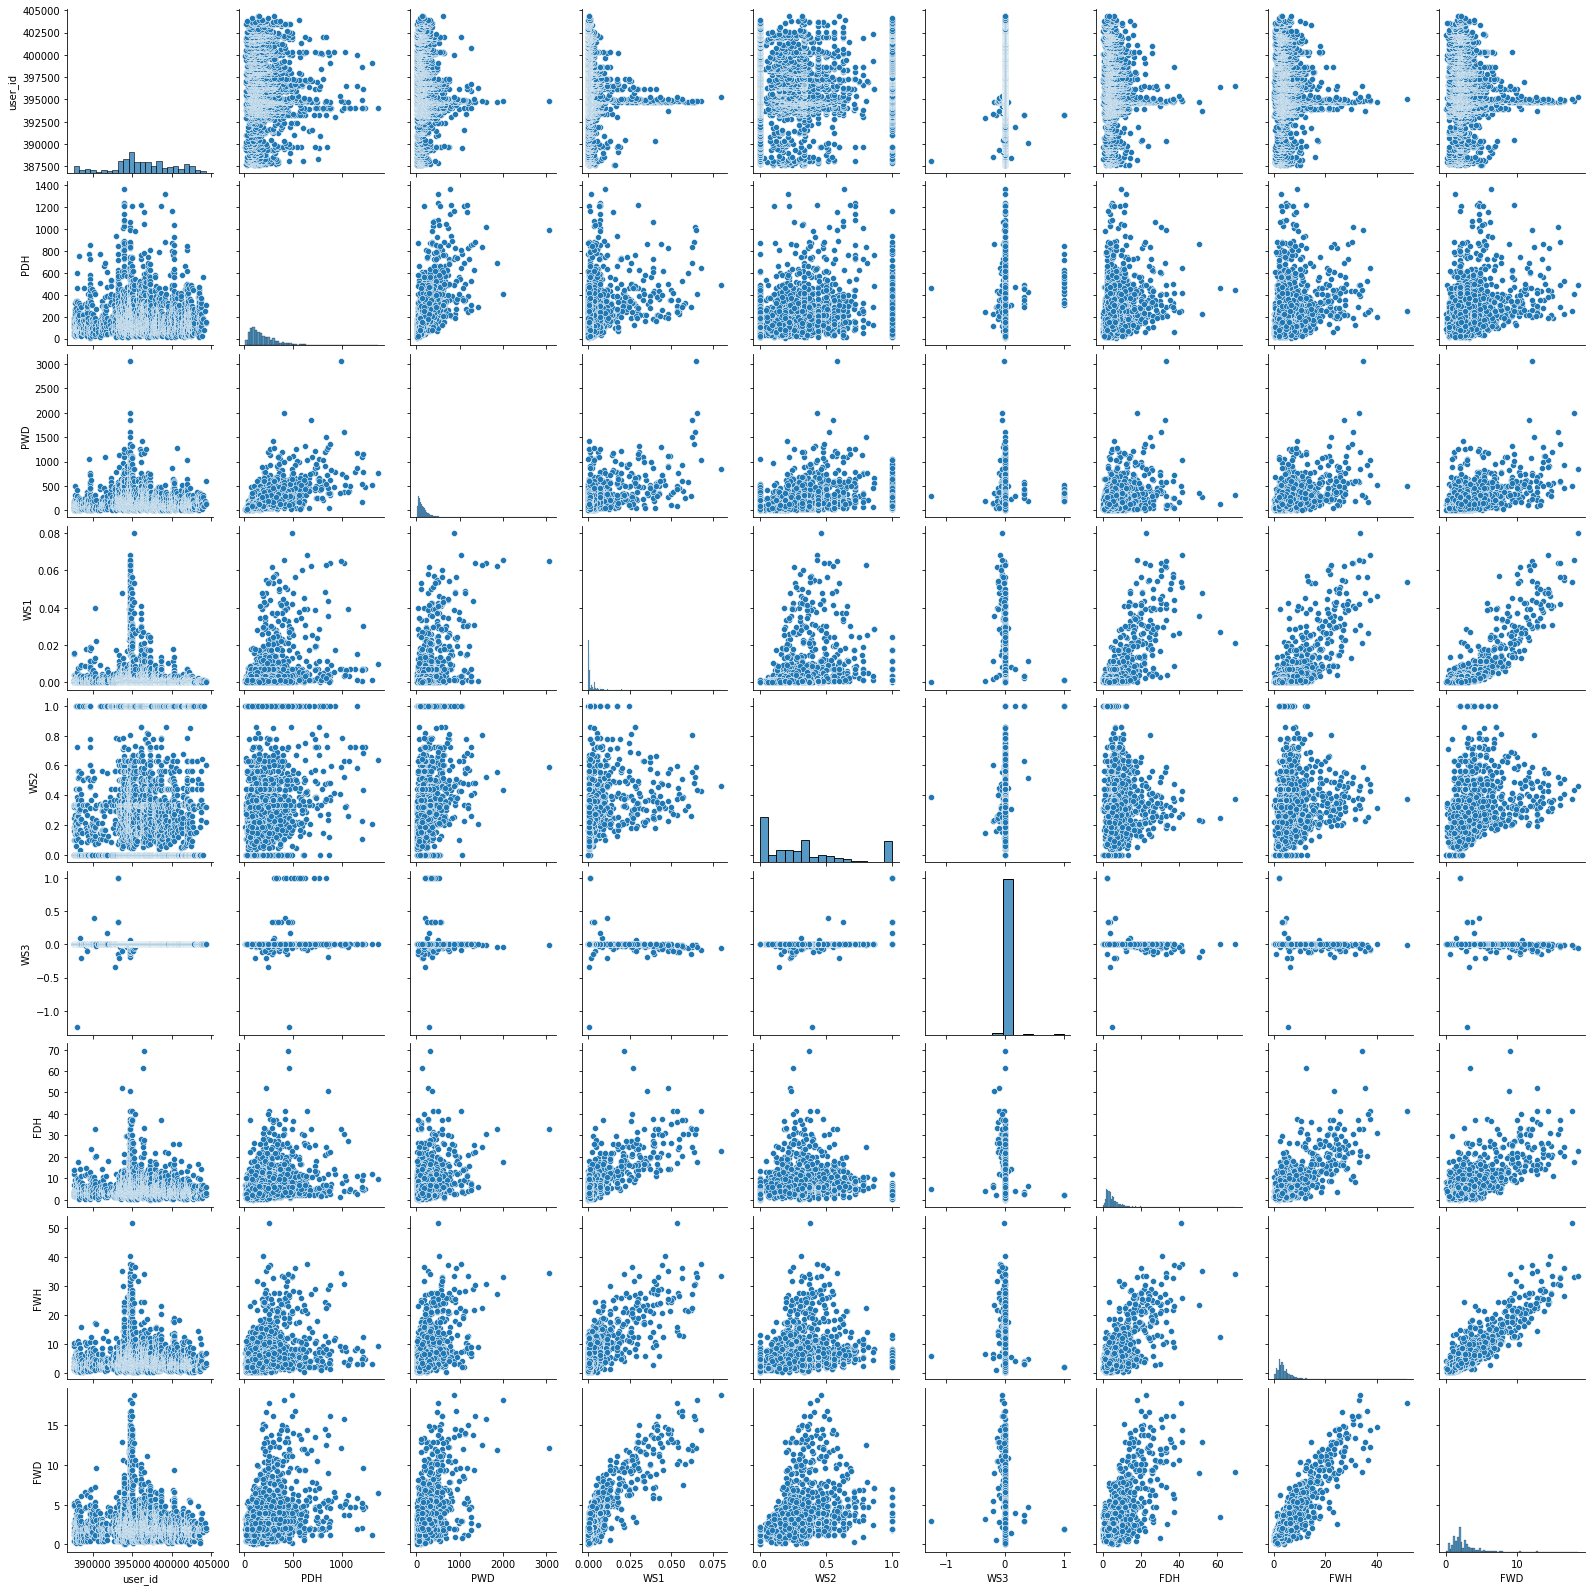

In [41]:
# Visualizing data
sns.pairplot(df_regularity)
print("Scatter matrix of the regularity metrics (pairwise).")
plt.show()

#### Clustering the data

In [42]:
# Preparing the data
X = df_regularity.drop(columns='user_id')
users = df_regularity.user_id

print("This is what a single feature vector for clustering looks like:")
X.head(1)

This is what a single feature vector for clustering looks like:


,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
0,27.942484,14.605581,0.003871,0.188178,0.0,11.820073,9.180426,5.166201


In [43]:
# Detecting optimal number of clusters
scores = []
k_max = 10
# Single cluster case excluded, we start from 2
ks = range(2, k_max+1)

for k in tqdm(ks):
    kmeans = KMeans(n_clusters = k).fit(X)
    labels = kmeans.labels_
    scores.append(silhouette_score(X, labels, metric = 'euclidean'))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.31it/s]


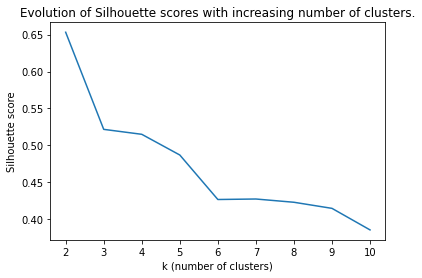

In [44]:
ax = sns.lineplot(x=ks, y=scores)
ax.set_title('Evolution of Silhouette scores with increasing number of clusters.')
ax.set_xlabel("k (number of clusters)")
ax.set_ylabel("Silhouette score")
plt.show()

**Note**: Our Silhouette score evolution seems to show that the less clusters the better, with the highest score being for 2 clusters. We will thus try 2 clusters and with no clustering at all.

The identified optimal number of clusters is 2.


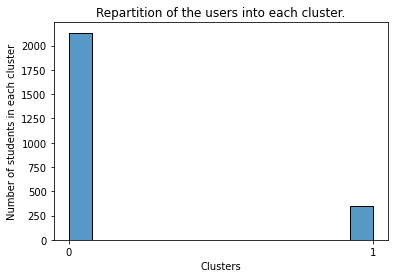

In [45]:
# Assigning the labels for the best k
best_k = np.argmax(scores) + 2
print(f"The identified optimal number of clusters is {best_k}.")

kmeans = KMeans(n_clusters = best_k).fit(X)
labels = kmeans.labels_

# Getting info on cluster repartition
ax = sns.histplot(labels)
ax.set_title('Repartition of the users into each cluster.')
ax.set_xlabel('Clusters')
ax.set_xticks(range(0, best_k), labels=range(0, best_k))
ax.set_ylabel('Number of students in each cluster')
plt.show()

In [46]:
# Getting cluster label
df_clusters = users.to_frame()
df_clusters['cluster'] = labels
df_clusters.sample(5)

,user_id,cluster
683,394284.0,0
985,394969.0,0
815,394629.0,0
378,393217.0,1
1451,396661.0,0


In [49]:
# Saving clusters data
filename = 'df_clusters_k' + str(best_k) + '.csv.gz'
path = data_loc + 'processed/'

_check = input(f"Are you certain that you want to save {filename} to {path}? \n[yes/no]")
if _check == 'yes':
    df_clusters.to_csv(path + filename)
    print("Saved!")

Are you certain that you want to save df_clusters_k2.csv.gz to ../../data/processed/? 
[yes/no] yes


Saved!


### Level Check Prediction (Classification)

The classification aims at predicting if level checks are going to be validated (passed) or not, using historic activity data. For this, we use a time series dataset formed with relevant actions of the user and their details.

Therefore, for each student, the features are a multi-dimensional time series. Each dimension corresponds to an information among the following (for each week):
- **total number** of actions for this week,
- **one-hot encoding** for the count of occurences of each of <br>
[`REVIEW_TASK`, `SKIP`, `CLOSE`, `SUBMIT_ANSWER`, `GO_TO_THEORY`, `NEXT`, `VIEW_QUESTION`, `GO_TO_BUG_REPORT`, `OPEN_FEEDBACK`, `CLOSE_FEEDBACK`, `GO_TO_COMMENTS`, `SHARE`, `REQUEST_HINT`],
- **average time** spent on the actions of this week (for actions with a `commit_time` value)

In this version of the classification, the labels are the level checks results. However, there can be multiple level checks on multiple topics in a week. As we don't distinguish the topics from one another, we aggregate the results (passed or not) of all the level checks for each week. Aggregation is done with the following majority mechanism: <br>
*Category (pass or fail) with more than 50% of the results for this user for this week wins all.*

In order to train a time series classifier, we need **features** and **labels**. As explained above, the **labels** constitute the level checks results (pass in case of mastery score improvement, fail otherwise). Each label has a week information. It holds the week at which the level check was done. <br>
The **features** are also detailed above. They are constituted of a set of features with values for each week of the time series.<br>
Then in order to **create the dataset**, we create for each label a time serie going from the beginning of our time frame (week 0) up to the week preceeding the level check.

#### Utils

In [50]:
def build_time_ref(df_features):
    """
    Creates a simple DataFrame with a single column enumerating the weeks from the minimum 
    up to the maximum week number observed in the data.
    """
    min_week = df_features.week.min()
    max_week = df_features.week.max()
    time_ref = pd.DataFrame(range(min_week, max_week)).rename(columns = {0:'week'})
    return time_ref

def build_actions_ref(df_features, time_ref = None):
    """
    Creates a DataFrame filled with NaN with one column for the week enumeration and one for
    each of the actions detected in df_features.
    """
    if time_ref is None : time_ref = build_time_ref(df_features)
    
    actions_ref = df_features.action.unique()
    actions_ref = pd.DataFrame(columns=actions_ref, index=time_ref.index).reset_index().rename(columns={'index':'week'})
    return actions_ref

In [51]:
def build_num_actions_per_week(df_features, u, time_ref=None, _fill=0.0):
    """
    Gets and formats the 'num_actions_per_week' information from the input table for the specified user u.
    The result contains one line per week of the time series. NaNs are replaces with the _fill value.
    """
    if time_ref is None: time_ref = build_time_ref(df_features)
    
    # Getting info
    num_actions_per_week = df_features.loc[df_features.user_id == u, ['week', 'num_actions_per_week']].drop_duplicates(['week', 'num_actions_per_week'])
    # Filling the gaps in weeks to form time series
    num_actions_per_week = num_actions_per_week.merge(time_ref, on='week', how='right').fillna(_fill)
    return num_actions_per_week

In [52]:
def build_one_hot_actions(df_features, u, actions_ref=None, time_ref=None, _fill=0.0):
    """
    Fills in the action_ref template with the count of the action for the designated week, for the specified user u.
    NaNs are filled with the _fill value.
    """
    if time_ref is None: time_ref = build_time_ref(df_features)
    if actions_ref is None: actions_ref = build_actions_ref(df_features)
    
    # Store the unique actions' dataframes.
    actions = []

    for c in actions_ref.columns[1:]:
        # Getting the count for each action for each week
        one_hot_action = df_features.loc[(df_features.user_id == u) & (df_features.action == c), ['week']].reset_index().groupby(['week']).count().reset_index().rename(columns={'index':c})
        # Merging to account for all weeks
        one_hot_action = one_hot_action.merge(time_ref, how='right', on='week').fillna(_fill)

        actions.append(one_hot_action)

    one_hot_actions = reduce(lambda left, right : left.merge(right, how='outer', on='week') , actions)
    
    return one_hot_actions


In [53]:
def build_elapsed_time(df_features, u, average=np.mean, time_ref = None, _fill=0.0):
    """
    Builds the elapsed time feature accounting for the average time spent on actions each week.
    Actions are not distinguished. Only actions with a `commit_time` value are taken into account.
    NaNs are filled with the _fill value.
    """
    # Extracts the valid data (non NaN commit_time)
    elapsed_time = df_features.loc[(df_features.user_id == u) & (~df_features.commit_time.isna()), ['week', 'start_time', 'commit_time']]
    # Compute elasped time values
    elapsed_time['elapsed_time'] = elapsed_time.commit_time - elapsed_time.start_time

    # Compute the average of these values
    elapsed_time = elapsed_time.groupby('week').agg(average).reset_index()[['week', 'elapsed_time']]
    # Formats to time serie & fills NaNs
    elapsed_time = elapsed_time.merge(time_ref, on='week', how='right').fillna(0.0)
    
    return elapsed_time

In [70]:
def aggregate_level_check_scores(r, threshold = 0.5) :
    """
    Aggregates the level checks for multiple level checks in a single week for a single user.
    """
    pass_ratio = sum(r) / len(r)
    return pass_ratio > threshold

In [65]:
def create_week_number(d):
    return (d.isocalendar()[0]-2021)*53 + d.isocalendar()[1]-1

#### Data Loading

In [54]:
path = data_loc + 'processed/data.csv.gz'

df_features = pd.read_csv(path)
df_features.head()

,user_id,timestamp,week,category,action,start_time,commit_time,max_num_tasks,num_checks,num_participations,num_actions_per_week,num_weeks_per_user
0,387604.0,2022-02-18 15:13:38.387,40,SESSION,REVIEW_TASK,1645197218251,1.645197e+12,5,11,5,7,6
1,387604.0,2022-02-18 15:13:40.545,40,SESSION,SKIP,1645197218251,1.645197e+12,5,11,5,7,6
2,387604.0,2022-02-18 15:13:43.057,40,SESSION,REVIEW_TASK,1645197222948,NaN,5,11,5,7,6
3,387604.0,2022-02-18 15:13:30.415,40,SESSION,REVIEW_TASK,1645197210317,1.645197e+12,5,11,5,7,6
4,387604.0,2022-02-18 15:13:37.975,40,SESSION,SKIP,1645197210317,1.645197e+12,5,11,5,7,6


In [55]:
path = data_loc + 'processed/df_level_check.csv.gz'

df_labels = pd.read_csv(path, index_col=0)
df_labels.head()

,user_id,date,change,validated,topic
0,387604,2021-06-04 02:23:12.297,"(3, 7.3753531662002505, 7.3753531662002505)",True,Spelling principles
1,387604,2021-06-04 02:23:12.297,"(2055, 3.981179459718665, 3.981179459718665)",True,Large and lower case
2,387604,2021-06-04 02:23:12.297,"(2065, 1.1930505543060275, 1.1930505543060275)",True,Spellishly difficult words
3,387604,2021-06-04 02:23:12.297,"(3163, 4.325001746856052, 4.325001746856052)",True,Comma in sentence
4,387604,2021-06-04 02:23:12.297,"(3110, 0.4742587317756678, 0.4742587317756678)",True,Verb


#### Features building exploration

In [56]:
u = 387604.0

# Building time and actions reference DFs
time_ref = build_time_ref(df_features)
print('time_ref (1st line):')
display(time_ref.head(1))

actions_ref = build_actions_ref(df_features)
print('actions_ref (1st line):')
display(actions_ref.head(1))

time_ref (1st line):


,week
0,0


actions_ref (1st line):


,week,REVIEW_TASK,SKIP,CLOSE,SUBMIT_ANSWER,GO_TO_THEORY,NEXT,VIEW_QUESTION,GO_TO_BUG_REPORT,OPEN_FEEDBACK,CLOSE_FEEDBACK,GO_TO_COMMENTS,SHARE,REQUEST_HINT
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# Building the num actions per week 
num_actions_per_week = build_num_actions_per_week(df_features, u, time_ref=time_ref)
num_actions_per_week.head(7)

,week,num_actions_per_week
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,16.0


In [58]:
# Building the one hot encoding of actions
one_hot_actions = build_one_hot_actions(df_features, u, actions_ref=actions_ref, time_ref=time_ref)
one_hot_actions.head(3)

,week,REVIEW_TASK,SKIP,CLOSE,SUBMIT_ANSWER,GO_TO_THEORY,NEXT,VIEW_QUESTION,GO_TO_BUG_REPORT,OPEN_FEEDBACK,CLOSE_FEEDBACK,GO_TO_COMMENTS,SHARE,REQUEST_HINT
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Computing the average time spent on an action per week 
elapsed_time = build_elapsed_time(df_features, u, average=np.mean, time_ref=time_ref)
elapsed_time.head()

,week,elapsed_time
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [60]:
# Aggregate all into final feature vector
_all = [num_actions_per_week, elapsed_time, one_hot_actions]
_X = reduce(lambda left, right : left.merge(right, how='outer', on='week') , _all).set_index('week')
_X.head()

,num_actions_per_week,elapsed_time,REVIEW_TASK,SKIP,CLOSE,SUBMIT_ANSWER,GO_TO_THEORY,NEXT,VIEW_QUESTION,GO_TO_BUG_REPORT,OPEN_FEEDBACK,CLOSE_FEEDBACK,GO_TO_COMMENTS,SHARE,REQUEST_HINT
week,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Building features for all users

In [61]:
users = df_features.user_id.unique()

# Building time and actions reference DFs
time_ref = build_time_ref(df_features)
actions_ref = build_actions_ref(df_features)

X = []

filename = 'classification_features.pickle'
path = data_loc + 'processed/'

if filename not in os.listdir(path):
    for u in tqdm(users):
        # Building the num actions per week 
        num_actions_per_week = build_num_actions_per_week(df_features, u, time_ref=time_ref)

        # Building the one hot encoding of actions
        one_hot_actions = build_one_hot_actions(df_features, u, actions_ref=actions_ref, time_ref=time_ref)

        # Computing the average time spent on an action per week 
        elapsed_time = build_elapsed_time(df_features, u, average=np.mean, time_ref=time_ref)

        # Aggregate all into final feature vector
        _all = [num_actions_per_week, elapsed_time, one_hot_actions]
        _X = reduce(lambda left, right : left.merge(right, how='outer', on='week') , _all).set_index('week')

        X.append((u, _X))
else:
    print(f"{filename} were found in the {path}.")
    with open(path + filename, "rb") as f :
        X = pickle.load(f)

classification_features.pickle were found in the ../../data/processed/.


In [63]:
# Save the features
path = data_loc + 'processed/'
filename = 'classification_features.pickle'

_check = input(f"Are you certain that you want to save {filename} to {path}? \n[yes/no]")
if _check == 'yes':
    with open(path+filename, "wb") as f :
        pickle.dump(X, f)
    print("Saved!")

Are you certain that you want to save classification_features.pickle to ../../data/processed/? 
[yes/no] no


In [89]:
# Load the features
path = data_loc + 'processed/'
filename = 'classification_features.pickle'

with open(path + filename, "rb") as f :
    X = pickle.load(f)

#### Building labels

In [66]:
# Getting min week number
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
events['timestamp'] = pd.to_datetime(events.timestamp, unit='ms').progress_apply(create_week_number)
week_min = events['timestamp'].min()
del events
print(f"Max week number found is {week_min}.")

100%|████████████████████████████████████████████████████████████████████| 3465559/3465559 [00:14<00:00, 236300.98it/s]


Max week number found is 19.


In [67]:
# Change date to week
df_labels['date'] = pd.to_datetime(df_labels.date)
df_labels['week'] = df_labels.date.apply(create_week_number)
# NOTE: the min is taken from the events DF as the level checks DF may miss some weeks
df_labels['week'] -= week_min
df_labels.head()

,user_id,date,change,validated,topic,week
0,387604,2021-06-04 02:23:12.297,"(3, 7.3753531662002505, 7.3753531662002505)",True,Spelling principles,2
1,387604,2021-06-04 02:23:12.297,"(2055, 3.981179459718665, 3.981179459718665)",True,Large and lower case,2
2,387604,2021-06-04 02:23:12.297,"(2065, 1.1930505543060275, 1.1930505543060275)",True,Spellishly difficult words,2
3,387604,2021-06-04 02:23:12.297,"(3163, 4.325001746856052, 4.325001746856052)",True,Comma in sentence,2
4,387604,2021-06-04 02:23:12.297,"(3110, 0.4742587317756678, 0.4742587317756678)",True,Verb,2


In [68]:
# Drop date, change and topic
df_labels = df_labels.drop(columns=['date', 'change', 'topic'])[['user_id', 'week', 'validated']]
df_labels.head()

,user_id,week,validated
0,387604,2,True
1,387604,2,True
2,387604,2,True
3,387604,2,True
4,387604,2,True


In [69]:
# Checking classes balances
_passed = df_labels.validated.sum()/df_labels.shape[0]
_failed = (~df_labels.validated).sum()/df_labels.shape[0]
print(f"Before aggregation, the VALIDATED level checks represent {_passed*100:.2f}% of the data.")
print(f"Before aggregation, the FAILED level checks represent {_failed*100:.2f}% of the data.")

Before aggregation, the VALIDATED level checks represent 73.81% of the data.
Before aggregation, the FAILED level checks represent 26.19% of the data.


In [71]:
# Aggregate level check results
Y = df_labels.groupby(['user_id', 'week']).agg(aggregate_level_check_scores).reset_index()

_passed = Y.validated.sum()/Y.shape[0]
_failed = (~Y.validated).sum()/Y.shape[0]
print(f"Before aggregation, the VALIDATED level checks represent {_passed*100:.2f}% of the data.")
print(f"Before aggregation, the FAILED level checks represent {_failed*100:.2f}% of the data.")

Before aggregation, the VALIDATED level checks represent 71.43% of the data.
Before aggregation, the FAILED level checks represent 28.57% of the data.


In [72]:
# Store labels
path = data_loc + 'processed/'
filename = 'df_labels.csv.gz'

_check = input(f"Are you certain that you want to save {filename} to {path}? \n[yes/no]")
if _check == 'yes':
    Y.to_csv(path + filename)
    print("Saved!")

Are you certain that you want to save df_labels.csv.gz to ../../data/processed/? 
[yes/no] no


In [73]:
# Load labels
path = data_loc + 'processed/df_labels.csv.gz'
Y = pd.read_csv(path, index_col=0)
Y.head()

,user_id,week,validated
0,387604,2,True
1,387604,17,False
2,387604,18,True
3,387604,27,False
4,387604,28,True


#### Building Classification Dataset

In [91]:
## Classification dataset creation

path = data_loc + 'processed/classification_features.pickle'
with open(path, "rb") as f :
    X = pickle.load(f)

# Converting features to a dict of datasets
X = [(int(_id), df) for (_id, df) in X]
X = dict(X)

# Load labels
path = data_loc + 'processed/df_labels.csv.gz'
Y = pd.read_csv(path, index_col=0)

In [92]:
df = Y.copy()
df.head()

,user_id,week,validated
0,387604,2,True
1,387604,17,False
2,387604,18,True
3,387604,27,False
4,387604,28,True


In [109]:
# Creating the features and labels in one DF (features col holds an entire DF)
df['features'] = df.apply(lambda r : X[r.user_id].iloc[range(r.week)] if r.user_id in X.keys() else np.NaN, axis=1)
df.head()

,user_id,week,validated,features
0,387604,2,True,num_actions_per_week elapsed_time REVI...
1,387604,17,False,num_actions_per_week elapsed_time REVI...
2,387604,18,True,num_actions_per_week elapsed_time REVI...
3,387604,27,False,num_actions_per_week elapsed_time REVI...
4,387604,28,True,num_actions_per_week elapsed_time REVI...


In [113]:
# Remove users labels for which we have no labels (np.NaN in features col)
df = df.loc[~df.features.isna()]

In [138]:
# Save the combined dataset
path = data_loc + 'processed/'
filename = 'df_classification_features_labels.pickle'

_check = input(f"Are you certain that you want to save {filename} to {path}? \n[yes/no]")
if _check == 'yes':
    df.to_pickle(path + filename)
    print("Saved!")

Are you certain that you want to save df_classification_features_labels.pickle to ../../data/processed/? 
[yes/no] yes


Saved!


#### Classification

In [3]:
# Load the combined dataset
path = data_loc + 'processed/'
filename = 'df_classification_features_labels.pickle'

df = pd.read_pickle(path + filename)

In [4]:
# Extract the features and transform them to timeseries format
_X = df.features.apply(lambda df : df.to_numpy()).to_numpy()
tmp = to_time_series_dataset(_X)

print(f"Created the Time Series dataset composed of {tmp.shape[0]:,} samples.")
print(f"Each sample has up to {tmp.shape[1]} time steps and {tmp.shape[2]} features.")
print(f"Total shape: {tmp.shape}.")

Created the Time Series dataset composed of 18,592 samples.
Each sample has up to 37 time steps and 15 features.
Total shape: (18592, 37, 15).


In [5]:
# Extract the labels and transform them into list of 1/0 labels
_Y = df.validated.apply(int).tolist()

print(f"Created the corresponding 1|0 labels dataset composed of {len(_Y):,} samples.")

Created the corresponding 1|0 labels dataset composed of 18,592 samples.


In [6]:
# Split into a train and test set
test_ratio = 0.2
validation_ratio = 0.1

X_train, X_test, Y_train, Y_test = train_test_split(_X, _Y, test_size=test_ratio, random_state=seed)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_ratio, random_state=seed)

print(f"Train sets size: {X_train.shape[0]:,} samples.")
print(f"Validation sets size: {X_val.shape[0]:,} samples.")
print(f"Test sets size: {X_test.shape[0]:,} samples.")

Train sets size: 13,385 samples.
Validation sets size: 1,488 samples.
Test sets size: 3,719 samples.


In [7]:
## Correcting class imbalance

# Getting samples indices per class
classes = [0, 1]
classes = [[i for i, y in enumerate(Y_train) if y==c] for c in classes]
_lengthes = list(map(len, classes))

# Computing desired number of samples in each class
upsampling_ratio = 0.5
_max, _min = max(_lengthes), min(_lengthes)
n_samples = int( upsampling_ratio * _max + (1-upsampling_ratio) * _min )

print(f"Minority class: {_min:,} samples.\nMajority class: {_max:,} samples.")
print(f"Upsampling by {upsampling_ratio*100:.2f}%, each class contains {n_samples:,} samples.")

# Resampling to match desired number of samples in each class
balanced = []
for c in classes:
    balanced.append(resample(c, random_state=seed, n_samples=n_samples) )

# Verifying and concatenating all in one array
assert(all([len(c) == n_samples for c in balanced]))
balanced = np.concatenate(balanced)

# Reassigning the samples to balance the training set
Y_train_b = np.array(Y_train)[balanced]
X_train_b = np.array(X_train)[balanced]

# Verifying that the classes are balanced as expected
assert(all([len([y for y in Y_train_b if y==c]) == n_samples for c in [0, 1]]))

Minority class: 3,811 samples.
Majority class: 9,574 samples.
Upsampling by 50.00%, each class contains 6,692 samples.


In [8]:
# Convert to time series dataset
X_train_b = to_time_series_dataset(X_train_b)
X_val = to_time_series_dataset(X_val)
X_test = to_time_series_dataset(X_test)

##### TimeSeriesSVC

Using Time Series classifier [TimeSeriesSVC](https://tslearn.readthedocs.io/en/stable/gen_modules/svm/tslearn.svm.TimeSeriesSVC.html#tslearn.svm.TimeSeriesSVC) from `tslearn`.

In [60]:
# Train a classifier for an increasing number of samples to tackle infeasibility due to quadratic scaling

n_samples = np.array([int(x) for x in np.linspace(10, len(Y_train_b))])
classifiers = []

path = data_loc + 'processed/'
filename = 'TimeSeriesSVC.pickle'

if filename not in os.listdir(path):
    for _n_samples in n_samples:
        print(f"Training with {_n_samples} samples...")

        x, y = resample(X_train_b, Y_train_b, random_state=seed, n_samples=_n_samples)

        clf = TimeSeriesSVC(C=1.0, kernel="gak", n_jobs=-1, verbose=1, gamma=1/_n_samples)
        clf.fit(x, y)

        classifiers.append((_n_samples, clf))
        print(f"Done!")
        
else : 
    print(f"Found {filename} in {path}! Loading precomputed instead...")
    with open(path+filename, "rb") as f :
        classifiers = pickle.load(f)
    print("Loaded!")

Training with 10 samples...
[LibSVM]Done!
Training with 282 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.5s
[Parallel(n_jobs

[LibSVM]Done!
Training with 555 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 828 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 1101 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 1374 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 1647 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 1920 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 2193 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 2466 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 2739 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 3012 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 3285 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 3558 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 3831 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 4104 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 4377 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

[LibSVM]Done!
Training with 4649 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

KeyboardInterrupt: 

In [70]:
# Save the classifiers
path = data_loc + 'processed/'
filename = 'TimeSeriesSVC.pickle'

_check = input(f"Are you certain that you want to save {filename} to {path}? \n[yes/no]")
if _check == 'yes':
    with open(path + filename, "wb") as f :
        pickle.dump(classifiers, f)
    print("Saved!")

Are you certain that you want to save TimeSeriesSVC.pickle to ../../data/processed/? 
[yes/no] yes


In [87]:
# Load the classifiers
path = data_loc + 'processed/TimeSeriesSVC.pickle'
with open(path, "rb") as f :
    classifiers = pickle.load(f)

In [ ]:
# Performing prediction on validation set
predictions_val = []

for _n_samples, c in classifiers:
    print(f"Computing validation predictions for classifier trained with {_n_samples} samples...")
    _predictions = c.predict(X_val)
    predictions_val.append((_n_samples, _predictions))
    print("Done!")

Computing validation predictions for classifier trained with 10 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 282 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 555 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 828 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 1101 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 1374 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 1647 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 1920 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 2193 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 2466 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 2739 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 3012 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 3285 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

Done!
Computing validation predictions for classifier trained with 3558 samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

##### KNeighborsTimeSeriesClassifier

Using Time Series classifier [KNeighborsTimeSeriesClassifier](https://tslearn.readthedocs.io/en/stable/gen_modules/neighbors/tslearn.neighbors.KNeighborsTimeSeriesClassifier.html#tslearn.neighbors.KNeighborsTimeSeriesClassifier) from `tslearn`.

In [63]:
# Train a KNN classifier for an increasing number of samples to tackle infeasibility due to quadratic scaling

n_samples = np.array([int(x) for x in np.linspace(10, len(Y_train_b))])
KNN_results = []

path = data_loc + 'processed/'
filename = 'KNNTimeSeriesClassification_validation.pickle'

if filename not in os.listdir(path):
    for _n_samples in n_samples:
        print(f"Training with {_n_samples} samples...")

        x, y = resample(X_train_b, Y_train_b, random_state=seed, n_samples=_n_samples)

        clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, verbose=1, n_jobs=-1)
        clf.fit(x, y)
        _KNN_results = clf.predict(X_val)

        KNN_results.append((_n_samples, _KNN_results))
        print(f"Done!")

else:
    print(f"Found {filename} in {path}! Loading precomputed instead..")
    with open(path+filename, "rb") as f :
    KNN_results = pickle.load(f)
    print("Loaded!")

Training with 10 samples...
Done!
Training with 282 samples...
Done!
Training with 555 samples...
Done!
Training with 828 samples...
Done!
Training with 1101 samples...
Done!
Training with 1374 samples...
Done!
Training with 1647 samples...
Done!
Training with 1920 samples...
Done!
Training with 2193 samples...
Done!
Training with 2466 samples...
Done!
Training with 2739 samples...
Done!
Training with 3012 samples...
Done!
Training with 3285 samples...
Done!
Training with 3558 samples...
Done!
Training with 3831 samples...
Done!
Training with 4104 samples...
Done!
Training with 4377 samples...
Done!
Training with 4649 samples...
Done!
Training with 4922 samples...
Done!
Training with 5195 samples...
Done!
Training with 5468 samples...
Done!
Training with 5741 samples...
Done!
Training with 6014 samples...
Done!
Training with 6287 samples...


KeyboardInterrupt: 

In [65]:
# Save validation sets predictions
path = data_loc + 'processed/'
filename = 'KNNTimeSeriesClassification_validation.pickle'

_check = input(f"Are you certain that you want to save {filename} to {path}? \n[yes/no]")
if _check == 'yes':
    with open(path+filename, "wb") as f :
        pickle.dump(KNN_results, f)
    print("Saved!")

In [ ]:
# Load validation sets predictions
path = data_loc + 'processed/'
filename = 'KNNTimeSeriesClassification_validation.pickle'

with open(path+filename, "rb") as f :
    KNN_results = pickle.load(f)

## Task 3: Model Evaluation

We evaluate the results of the classifiers on the validation and test sets. As we are in the case of binary classification, we use the following metrics in order to assess the quality of the trained models:
- accuracy
- balanced accuracy
- precision, recall and F1 score

We also use the confusion matrix in order to further analyze the classifiers' performances. 

In [ ]:
def get_metrics_dict(y_true, y_pred, report = True, target_names=['Failed', 'Passed']):
    """
    Prints a classification report and 
    computes the following set of binary classification metrics:
    - 'accuracy'
    - 'balanced_accuracy': accuracy taking class balance into account,
    - 'adjusted_balanced_accuracy' : balanced accuracy accounting for chance in classification
    - 'f1'
    - 'f1_weighted' : F1 score weighted by classes support,
    - 'matthews' : matthews binary classification correlation coefficient.
    """
    scores={}
    
    if report:
        print(metrics.classification_report(y_true, y_pred, target_names=target_names)

    scores['accuracy'] = metrics.accuracy_score(y_true, y_pred)

    scores['balanced_accuracy'] = metrics.balanced_accuracy_score(y_true, y_pred)
    
    scores['adjusted_balanced_accuracy'] = metrics.balanced_accuracy_score(y_true, y_pred, adjuted=True)

    scores['f1'] = metrics.f1_score(y_true, y_pred)

    scores['f1_weighted'] metrics.f1_score(y_true, y_pred, average='weighted')

    scores['matthews'] = metrics.matthews_corrcoef(y_true, y_pred)
    
    return scores

*Your discussion/interpretation about your model's behavior goes here*